# Project report

To extract text (in french and german, possibly itlian) from scanned documents, there are mainly 2 parts of task to perform:

1. text extraction   
    for this task I mainly used the `pyocr` module, to use it, have to install tesseract on the machine.
    
2. participant name extraction (possibily more informaitons such as title/subject of each doc)   
    for this task, I used `langid` for language detection, then use `nltk` for entity recognition. 
    

# task1: text extraction

First, I tried the problem with PIL and opencv for line detection and so on (see [section 0](#0.-Processing-using-PIL-and-opencv)). Using Hough transformation, I can detect the vertical line in the middle, but the results are not very good, and a lot of stuff have to be done to make it work.

In the spirit of enginnering rather than academic, I use `pyocr` (which uses tesseract-ocr in the backend) to do the text extracting job. 

In fact, the `tesseract-ocr` is a well developped package, and already supports common page-layout analysis. In [section 1](#1.-OCR-using-pyocr) as I have shown, with the `pyocr` module, we can not only extract raw text, but also extract lineboxes/wordboxes, which contain in additional **position information** of the recognized texts. 

# task2: name extraction

*The input of this part is the raw text extracted from the text extraction task.* The code is in [section 2](#2.-Participant-name-extraction).

To extract names, first use `nltk` to tokenize the raw text into sentences. Then for each sentence, use the `langid` module to detect its language (french or german), then use `nltk` to POS tag each word in sentece, and use `nltk.ne_chunk` (used for NER: named entity recognition) to recognize entity names. Then just output recognized PERSON entities as output. 

As the default tagger in nltk are for english, I have also tried the stanford tagger, but strange thing is, with this tagger, the chunker can't find any entities for french text. 

There also exists stanford NER modules, but there is no pretrained modules for french and german. 

# TODO: 

* paragraph seperation  
    With the position of line/word boxes, we can try to extract **paragraphs** by using the position information of the boxes. 

* dealing with line-changing hyphens  
    if we can do paragraph seperation, then can handle the hyphens when part of a word is at the end of a line. 

* ad-hoc solution for name extraction  
    an ad-hoc way for name extraction should be, after identifying paragraphs, just take the string before the semicolon of the first line of the paragraph, and use this as the name. For the test image this should work well, but I have to see if the scheme is valid for all scanned documents... 
    
* V/H line detection  
    The Hough transformation make some mistakes on the vertical/horizontal lines (see [section 0](#0.-Processing-using-PIL-and-opencv)), maybe should write a simple V/H line detector, because these lines can help us understand the structure of the document, and might be useful for extracting titles/subjects/etc... 
    



---

# 0. Processing using PIL and opencv

In [2]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab
pylab.rcParams['figure.figsize'] = (10, 10)
from PIL import Image
import cv2

### Read image

In [3]:
# reading image with PIL
img = Image.open('test.png')
print img.mode, img.size, img.format
aimg = np.asarray(img)
print aimg.shape # 4-channel RGBA image

RGBA (2454, 3600) PNG
(3600, 2454, 4)


In [4]:
# convert PIL img to grayscale
img = img.convert('L') 
aimg = np.asarray(img)

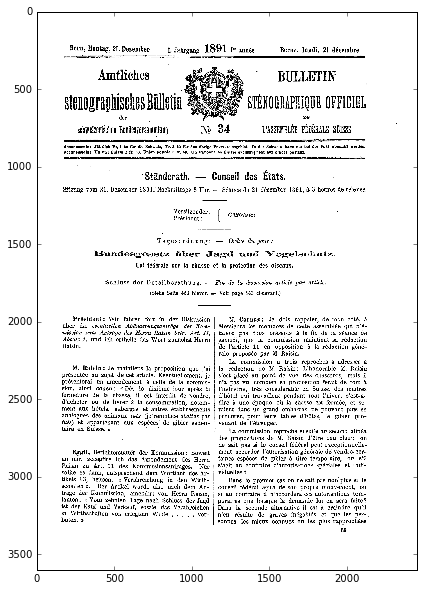

In [5]:
plt.imshow(np.asarray(img), cmap='gray')

In [6]:
# get width/height
W, H = img.size
print W, H

2454 3600


### Find the vertical seperating line in middle

In [9]:
# read img via opencv -- read into an np array
img = cv2.imread('test.png')
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # convert to grayscale
gray_img = cv2.GaussianBlur(gray_img,(3,3),0) # denoise image

# binarize img, via canny or thresholding
canny = cv2.Canny(gray_img, 50, 150, apertureSize=5) 
cv2.imwrite('canny.jpg', canny)

# canny image has empty areas inside central line --> maybe directly thresholding shoud be better ? 
binary = cv2.threshold(gray_img, 127,255, cv2.THRESH_BINARY_INV)[-1] 
cv2.imwrite('binary.jpg', binary)
# plt.imshow(binary)

True

Using Proba-version of Hough transformation to detect lines:

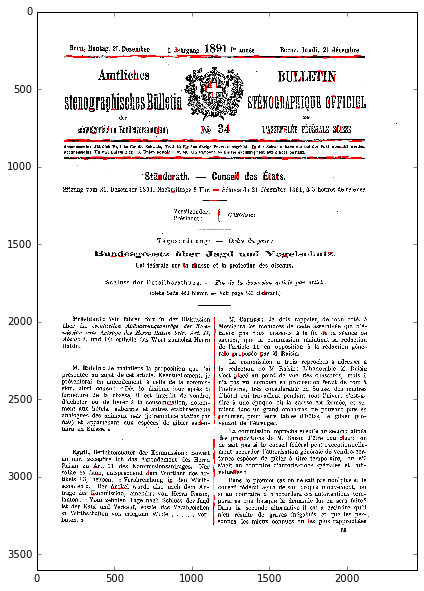

In [10]:
minLineLength = 100
maxLineGap = 20
lines = cv2.HoughLinesP(canny,1,np.pi/2,100,minLineLength,maxLineGap)

_img = img.copy()
for x1,y1,x2,y2 in lines.reshape(-1,4):
    cv2.line(_img,(x1,y1),(x2,y2),(255,0,0),5)

cv2.imwrite('out2.jpg',_img)
plt.imshow(_img)

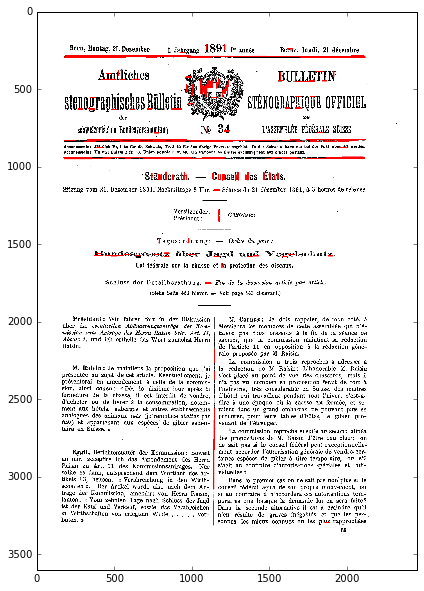

In [13]:
minLineLength = 100
maxLineGap = 30
lines = cv2.HoughLinesP(binary,1,np.pi/2,100,minLineLength,maxLineGap).reshape(-1,4)

_img = img.copy()
for x1,y1,x2,y2 in lines:
    cv2.line(_img,(x1,y1),(x2,y2),(255,0,0),5)

cv2.imwrite('out2_b.jpg',_img)
plt.imshow(_img)

**TODO: write my own V/H line detector, which should just be a 1d convolution of a all-1 kernel...**

Then for the seperating line we just take the average of the y values of detected lines

In [16]:
avg = []
for x1,y1,x2,y2 in lines:
    if x1==x2:
        avg.append(x1)
V_split = int(np.mean(avg))
print V_split

1139


### Crop the image into left and right part

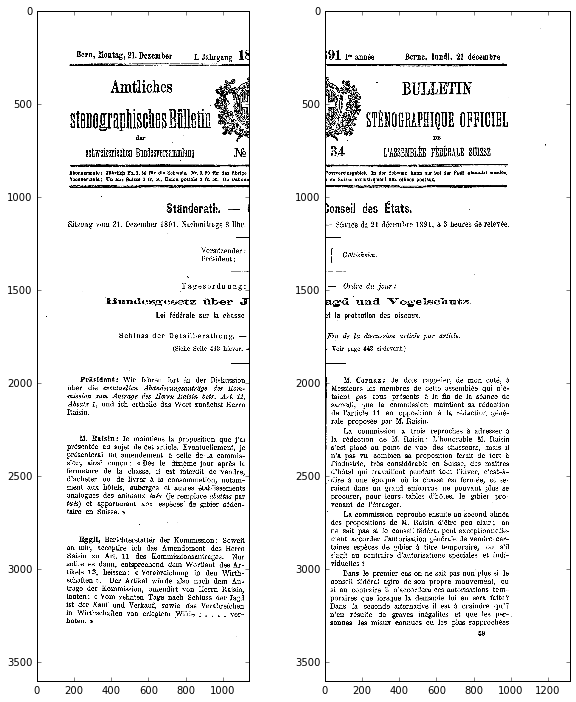

In [17]:
left_img = gray[:,0:V_split+2]
right_img = gray[:,V_split-2:]

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,12))
ax1.imshow(left_img, cmap='gray')
ax2.imshow(right_img, cmap='gray')

# 1. OCR using pyocr

In [15]:
import pyocr
import pyocr.builders
tool = pyocr.get_available_tools()[0]

In [20]:
gray_img = Image.fromarray(gray_img) # pyocr needs PIL image

### Explore what pyocr gives

#### Directly extract text

In [18]:
txt = tool.image_to_string(
    gray_img, 
    lang='deu+fra', 
    builder=pyocr.builders.TextBuilder() )

In [19]:
print txt

Bern, Montag, 21. Dezember Berne, lundi. 21 décembre
' BULLETIN
W - STENUGBAPHIQUE ornent
4 L’ASSEMBLÉE FEDERALE SUISSE
Abonnemente: “much Fr. 1. so fu: die Schweiz. Fr. 3. 50 fur du ubriga Po-tvereinsgebtot. In der Schweiz kann nur bal du Fos! about:: werden.
abonnements: Un an: Suisse [fr. 50, Union postale 8 fr. 50. On vabonno en Suisse exclusivement aux office: postaux.
I. Jahrgang 1891 I" année
Amtliches _ ’
stanngrapiisniesBülliii
sciweizsrisuen Bundesversammlunu
    
 
'Ständerath. — Conseil des États.
Sitzung vom 21. Dezember 18914 Nachmittags 3 Uhr. - Séance du 21 décembre 1891, a 3 heures de relevée.
Vorsitzender :
Président :
\
Tagesordnung:
{ Gôttz'shez'm.
—- Ordre du jour:
Bundesgesetz über J agd ‚und Vogelschutz.
Loi fédérale sur la chasse et la protection des oiseaux.
Schluss der Detailberathung. -— Fin de la discussion article par article.
(Siehe Seite 443 hievor. .- Voir page 443 ci-devant.)
Präsident: Wir fahren fort in der Diskussion
über die eventuellen Abänderungsa

#### lineboxes and word boxes

In [21]:
lineboxes = tool.image_to_string(
    gray_img,
    lang='deu+fra',
    builder=pyocr.builders.LineBoxBuilder() )

In [22]:
wordboxes = tool.image_to_string(
    gray_img,
    lang='deu+fra',
    builder=pyocr.builders.WordBoxBuilder())

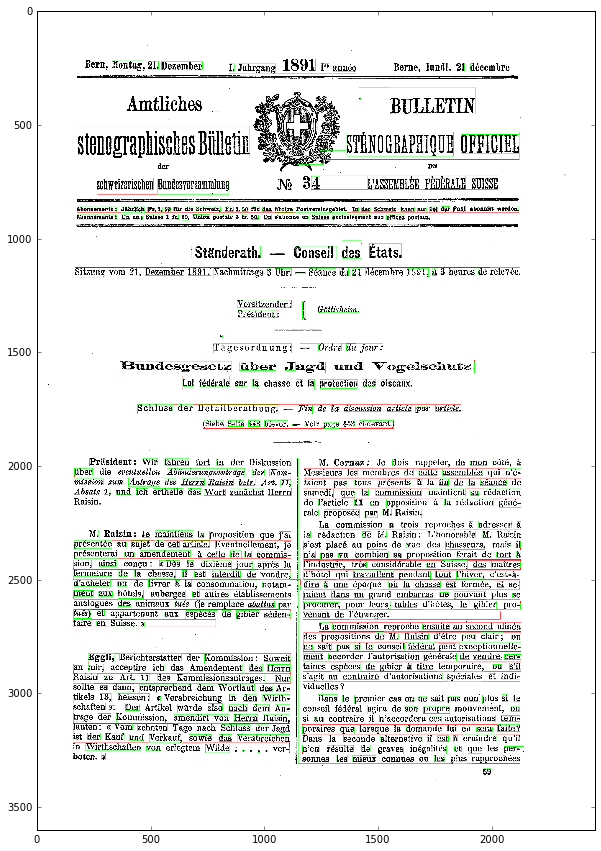

In [24]:
_img = img.copy()
for lnbox in lineboxes:
#     print linebox.content
    p1, p2 = lnbox.position
    cv2.rectangle(_img, p1, p2, (255,0,0) )

for wdbox in wordboxes:
    p1, p2 = wdbox.position
    cv2.rectangle(_img, p1, p2, (0,255,0))
    
cv2.imwrite('boxes.jpg', _img)
plt.figure(figsize=(10,20))
plt.imshow(_img)

# 2. Participant name extraction

The idea is to use langid for detecting the language of a sentence, then use nltk.ne_chunk to get entity names. 

**TODO: use stanford NER/POS package**

In [30]:
import nltk, cv2, langid
langid.set_languages(['de','fr','it']) # possible languages
# nltk.download() # when first time running 

In [31]:
def extract_names_nltk(text):
    for sent in nltk.sent_tokenize(text):
        lang, _ = langid.classify(sent)
        lang = {'it':'italian','fr':'french','de':'german'}[lang]
        print '==== %s ====' % lang
        print sent.replace('\n', ' ')
        tokens = nltk.word_tokenize(sent, language=lang)
        pos_tags = nltk.pos_tag( tokens )
        names = []
        for chunk in nltk.ne_chunk( pos_tags ):
            if hasattr(chunk, 'label'):
                if chunk.label()!='PERSON': continue
                name = ' '.join(c[0] for c in chunk.leaves())
                names.append(name)
                print chunk.label(), name
    return names

In [32]:
extract_names_nltk(txt)

==== german ====
Bern, Montag, 21.
PERSON Montag
==== german ====
Dezember Berne, lundi.
PERSON Berne
==== french ====
21 décembre ' BULLETIN W - STENUGBAPHIQUE ornent 4 L’ASSEMBLÉE FEDERALE SUISSE Abonnemente: “much Fr.
==== german ====
1. so fu: die Schweiz.
PERSON Schweiz
==== german ====
Fr.
==== german ====
3.
==== german ====
50 fur du ubriga Po-tvereinsgebtot.
==== german ====
In der Schweiz kann nur bal du Fos!
PERSON Schweiz
==== german ====
about:: werden.
==== french ====
abonnements: Un an: Suisse [fr.
==== italian ====
50, Union postale 8 fr.
PERSON Union
==== german ====
50.
==== french ====
On vabonno en Suisse exclusivement aux office: postaux.
==== german ====
I. Jahrgang 1891 I" année Amtliches _ ’ stanngrapiisniesBülliii sciweizsrisuen Bundesversammlunu        'Ständerath.
PERSON Amtliches
==== french ====
— Conseil des États.
==== german ====
Sitzung vom 21.
PERSON Sitzung
==== german ====
Dezember 18914 Nachmittags 3 Uhr.
==== french ====
- Séance du 21 décembre 18

#### Do POS tagging via stanford package

In [27]:
from nltk.tag.stanford import StanfordNERTagger, StanfordPOSTagger

In [29]:
# StanfordNERTagger() # no pretrained de/fr model for stanford NER...
st_fr = StanfordPOSTagger('../stanford-postagger-full-2015-12-09/models/french.tagger',
                         '../stanford-postagger-full-2015-12-09/stanford-postagger.jar')
st_de = StanfordPOSTagger('../stanford-postagger-full-2015-12-09/models/german-fast.tagger',
                         '../stanford-postagger-full-2015-12-09/stanford-postagger.jar')

In [33]:
def extract_names_stanford(text):
    for sent in nltk.sent_tokenize(text):
        lang, _ = langid.classify(sent)
        lang = {'it':'italian','fr':'french','de':'german'}[lang]
        print '==== %s ====' % lang
        print sent.replace('\n', ' ')
        tokens = nltk.word_tokenize(sent, language=lang)
        tagger = st_fr if lang=='french' else st_de
        pos_tags = tagger.tag(tokens)
        names = []
        for chunk in nltk.ne_chunk( pos_tags ):
            if hasattr(chunk, 'label'):
                if chunk.label()!='PERSON': continue
                name = ' '.join(c[0] for c in chunk.leaves())
                names.append(name)
                print chunk.label(), name
    return names

In [34]:
extract_names_stanford(txt)

==== german ====
Bern, Montag, 21.
PERSON Montag
==== german ====
Dezember Berne, lundi.
==== french ====
21 décembre ' BULLETIN W - STENUGBAPHIQUE ornent 4 L’ASSEMBLÉE FEDERALE SUISSE Abonnemente: “much Fr.
==== german ====
1. so fu: die Schweiz.
==== german ====
Fr.
==== german ====
3.
==== german ====
50 fur du ubriga Po-tvereinsgebtot.
==== german ====
In der Schweiz kann nur bal du Fos!
==== german ====
about:: werden.
==== french ====
abonnements: Un an: Suisse [fr.
==== italian ====
50, Union postale 8 fr.
==== german ====
50.
==== french ====
On vabonno en Suisse exclusivement aux office: postaux.
==== german ====
I. Jahrgang 1891 I" année Amtliches _ ’ stanngrapiisniesBülliii sciweizsrisuen Bundesversammlunu        'Ständerath.
PERSON Jahrgang
==== french ====
— Conseil des États.
==== german ====
Sitzung vom 21.
==== german ====
Dezember 18914 Nachmittags 3 Uhr.
==== french ====
- Séance du 21 décembre 1891, a 3 heures de relevée.
==== french ====
Vorsitzender : Président : \

# 3. TODO: Paragraph seperation